In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses. Analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [35]:
from lib.config import Config
from lib.dataset_loader import DatasetLoader
from lib.model_factory import ModelFactory
from lib.data_generator import SteeringWheelAngleDataGenerator
from lib.image_preprocessor import ImagePreprocessor
from lib.sample_augmenter import SampleAugmenter
from lib.callback_factory import CallbackFactory

from keras.optimizers import Adam
from keras import backend as K

**Step 2**: First of all check that has a GPU available. This is required to decrease learning training times: 

In [3]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  ['/job:localhost/replica:0/task:0/device:GPU:0']


**Step 3**: Load config file.

In [4]:
cfg = Config('./config.yml')

### Load Train data

The dataset was previously generater using de **Training Mode** of UDacity simulator. This mode generate:

1. **IMG** directory that contain images taked with all cameras(left, center, right)

2. **driving_log.csv** file that contain examples with next columns:

In [5]:
cfg['dataset']['columns']

['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

When:
* **Center**, **Left** and **Right**: Are images paths. That images was taked from three cameras mounted in front of a car in the simulator.
* **Steering**: The car steering whell angle.
* **Throttle**: Car aceletation.
* **Reverse**
* **Speed**: Car speed.

**Step 1**: Load dataset

In [6]:
loader = DatasetLoader(cfg)

dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels']
)




Images


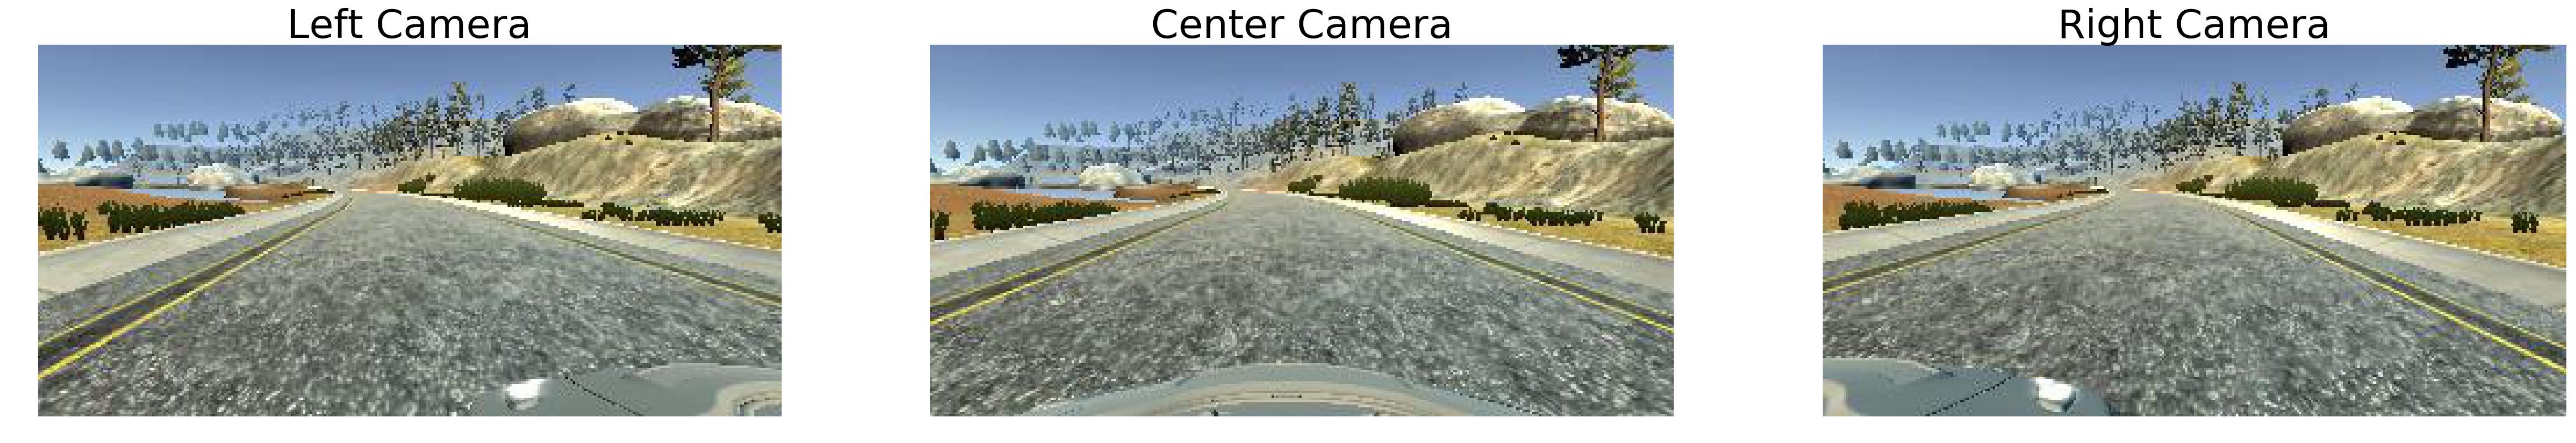

Steering Angle: 0.0




In [7]:
example = dataset[0]
example.show()

**Step 2**: Split dataset in train and validation.

In [8]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_percent'])

In [9]:
print("Train dataset examples: ", len(train_dataset))

Train dataset examples:  651


In [10]:
print("Validation dataset examples: ", len(validation_dataset))

Validation dataset examples:  163


### Create NVidia model

The model can get as input an image and predict next steering whell angle of the car.

**Step 1:** Define magic lambda that used to normalize images to avoid saturation and make gradients work better.

In [11]:
input_normalization=lambda x: x / 127.5 - 1.0

**Step 2:** Next let's define the input shape given three parameters:

In [12]:
image_height = cfg['dataset']['image']['height']
print('Input Image Height: ', image_height)

Input Image Height:  160


In [13]:
image_width = cfg['dataset']['image']['width']
print('Input Image Width: ', image_width)

Input Image Width:  320


The image channels refers to RGB color notation (red, green, blue):

In [14]:
image_channels = cfg['dataset']['image']['channels']
print('Input Image Channels: ', image_channels)

Input Image Channels:  3


Then define input shape:

Then an input shape is a tensor (a list of matrixes) of range 3:

In [15]:
input_shape=(image_height, image_width, image_channels)
input_shape

(160, 320, 3)

**Step 3:** Next define 50% dropout after las CNN layer <a href='#1.-Dropout'>[1]</a>:

In [16]:
cnn_end_dropout_rate=0.5

**Step 4:** Also use an activation function ELU <a href='#2.-Activation-Functions'>[2]</a>:

In [17]:
activation='elu'

**Step 5:** Create the model.




MODEL LAYERS

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 33, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 33, 64)        0   

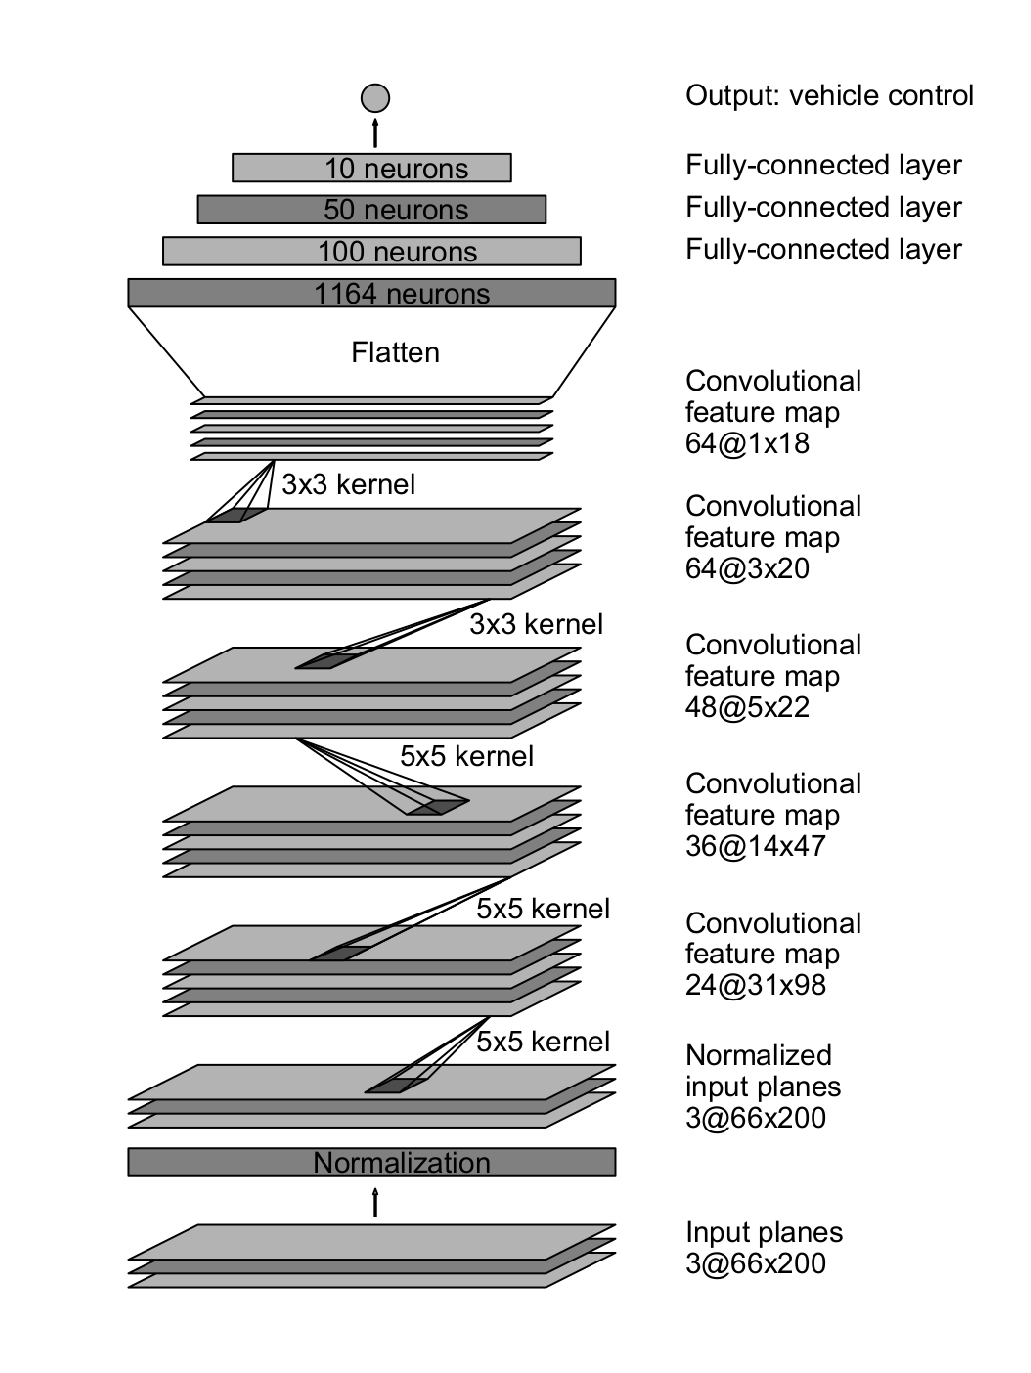

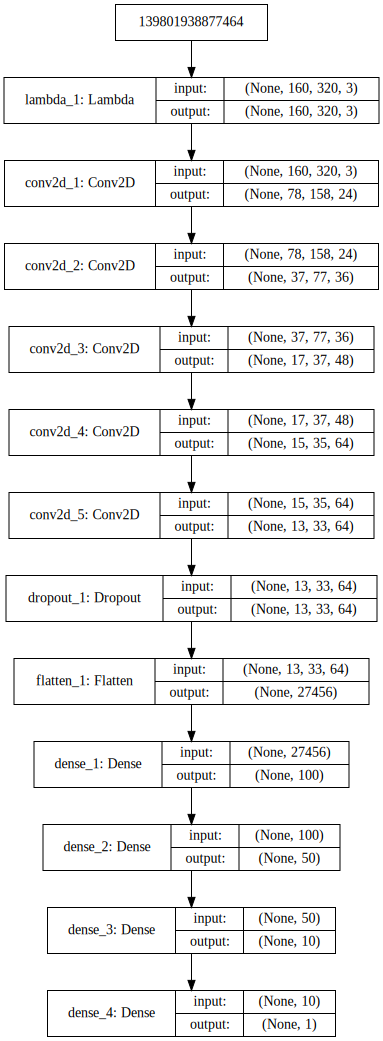

In [18]:
model = ModelFactory.create_nvidia_model(
    input_shape,
    input_normalization,
    cnn_end_dropout_rate,
    activation
)
model.show()

### Create data generators

In [19]:
work_path = cfg['train']['work_path']
print("Augment work path: ", work_path)

Image augment work path:  ./temp


In [20]:
threshold = cfg['train']['augment']['threshold']
print("Image augment threshold: ", threshold)

Image augment threshold:  0.6


In [21]:
batch_size = cfg['train']['batch_size']
print("Number of example by each batch: ", batch_size)

Number of example by each batch:  40


In [22]:
output_shape=(1)
print("Output shape: ", output_shape)

Output shape:  1


In [23]:
image_preprocessor=ImagePreprocessor()
sample_augmenter = SampleAugmenter(work_path, threshold)
output_shape=(1)

In [24]:
train_generator = SteeringWheelAngleDataGenerator(
    dataset=train_dataset,
    input_shape=input_shape,
    output_shape=output_shape,
    batch_size=batch_size,
    sample_augmenter=sample_augmenter,
    image_preprocessor=image_preprocessor
)

In [25]:
validation_generator = SteeringWheelAngleDataGenerator(
    dataset=validation_dataset,
    input_shape=input_shape,
    output_shape=output_shape,
    batch_size=batch_size,
    image_preprocessor=image_preprocessor
)

### Train Model

In [29]:
checkpount = CallbackFactory.create_checkpoint_that_save_model_when_reach_better_metric_value(
    model_name=model.name,
    metric='val_loss'
)

In [36]:
optimizer=Adam(lr=1.0e-4)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [37]:
steps_per_epoch=20000
epochs=10

In [38]:
model.train(
    train_generator=train_generator,
    validation_generator=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[checkpount]
) 

/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


ValueError: `validation_data` should be a tuple `(val_x, val_y, val_sample_weight)` or `(val_x, val_y)`. Found: <lib.data_generator.SteeringWheelAngleDataGenerator object at 0x7f25a4353940>

### References

##### 1. Dropout

* [Dropout](https://youtu.be/Ty6K6YiGdBs)
* [Dropout RENDER](https://youtu.be/6DcImJS8uV8)
* [Dropout Pt. 2 RENDER](https://youtu.be/8nG8zzJMbZw)

##### 2. Activation Functions

* [Introduction to Exponential Linear Unit](https://medium.com/@krishnakalyan3/introduction-to-exponential-linear-unit-d3e2904b366c)
* [Which Activation Function Should I Use?](https://youtu.be/-7scQpJT7uo)

#### 3. Data Generations

* [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)